#**Importing Libraries**

In [43]:
# Install OpenCV
!pip install opencv-python

In [44]:
import torch
import torch.nn as nn
from torch.nn import Conv2d
import torch.nn.functional as F
from torchvision import transforms

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, Activation, AveragePooling2D, MaxPooling2D

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import random
import pandas as pd

import zipfile as zf

files = zf.ZipFile("BHSig260.zip",'r')
files.extractall()
files.close()

In [46]:
thresh = 9.54321

#**Linear Interpolation**

In [48]:
def linear_interpolation(image, new_height, new_width):
    orig_height, orig_width = image.shape[:2]
    sx = new_width / orig_width
    sy = new_height / orig_height
    output_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    return output_image

def add_white_pixels(image, x_pixels, y_pixels):
    h, w = image.shape[:2]
    output_image = image.copy()
    output_image = cv2.copyMakeBorder(output_image, y_pixels, y_pixels, x_pixels, x_pixels, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    return output_image

### **Modified Multi-Contrastive Loss Function**

In [50]:
class MultiContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(MultiContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, label):
        alpha = 0.5
        beta = 0.3
        gamma = 0.2

        combined_distance = alpha * euclidean_distance_1 + beta * euclidean_distance_2 + gamma * euclidean_distance_3
        print("c : ", combined_distance)
        genuine_loss = (label * combined_distance ** 2).mean()
        forged_loss = ((1 - label) * torch.clamp(self.margin - combined_distance, min=0) ** 2).mean()
        loss = genuine_loss + forged_loss

        # if output == 1:
        #     # Genuine - Genuine pair
        #     loss = distance * distance
        # else:
        #     # Genuine - Forged pair
        #     err = torch.clamp(self.margin - distance, min = 0)
        #     loss = err * err

        return loss


#**Image Processing**

In [52]:
# # Load the genuine image

# folder = cv2.imread('/content/drive/MyDrive/Hindi/066')
# gen = cv2.imread('/content/drive/MyDrive/Hindi/066/H-S-66-G-01.tif')
# gray = cv2.cvtColor(gen, cv2.COLOR_BGR2GRAY)
# _, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

# contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
# for contour in contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     x_min = min(x_min, x)
#     y_min = min(y_min, y)
#     x_max = max(x_max, x + w)
#     y_max = max(y_max, y + h)

# cropped_image = gen[y_min:y_max, x_min:x_max]

# cv2.imwrite("H-S-122-G-30_cropped.tif", cropped_image)
# cv2.rectangle(gen, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
# gen_rgb = cv2.cvtColor(gen, cv2.COLOR_BGR2RGB)

# plt.imshow(gen_rgb)
# plt.title("Signature with Single Bounding Box")
# plt.axis("off")
# plt.show()

In [53]:
def image_processing_genuine(folder_no, folder_path):
  # import cv2
  # import matplotlib.pyplot as plt

  # # Path to the folder containing the images
  # folder_path = '/content/drive/MyDrive/Hindi/066'

  # # Get list of all images in the folder
  all_images = [img for img in os.listdir(folder_path) if img.endswith('.tif')]

  # Define the sequence range
  start_seq = "H-S-" + str(folder_no) + "-G-01"
  end_seq = "H-S-" + str(folder_no) + "-G-24"

  print(start_seq)
  print(end_seq)

  # Filter images within the specified sequence range
  filtered_images = [img for img in all_images if start_seq <= img <= end_seq]

  # Select a random image from the filtered list
  if not filtered_images:
      start_seq = "H-S-" + "0" + str(folder_no) + "-G-01"
      end_seq = "H-S-" + "0" + str(folder_no) + "-G-24"

      print(start_seq)
      print(end_seq)

      # Filter images within the specified sequence range
      filtered_images = [img for img in all_images if start_seq <= img <= end_seq]
      
  img_name_genuine = random.choice(filtered_images)
  img_path = os.path.join(folder_path, img_name_genuine)
  genuine = cv2.imread(img_path)
  gray = cv2.cvtColor(genuine, cv2.COLOR_BGR2GRAY)
  _, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

  contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      x_min = min(x_min, x)
      y_min = min(y_min, y)
      x_max = max(x_max, x + w)
      y_max = max(y_max, y + h)

  cropped_image_genuine = genuine[y_min:y_max, x_min:x_max]
  # cropped_image_genuine_ = genuine[y_min:y_max, x_min:x_max]
  cropped_image_genuine_name = img_name_genuine.replace(".tif", "_cropped.tif")
  path = 'C:\\Users\\Yashraj\\OneDrive - Indian Institute of Technology Patna\\Desktop\\MASCN_project\\Images_store'
  cv2.imwrite(os.path.join(path , cropped_image_genuine_name), cropped_image_genuine)
  # cv2.imwrite(cropped_image_genuine_name, cropped_image_genuine)
  cv2.rectangle(genuine, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
  # genuine_rgb = cv2.cvtColor(cropped_image_genuine, cv2.COLOR_BGR2RGB)
  # cv2.rectangle(genuine, (0, 0), (x_max-x_min, y_max-y_min), (0, 255, 0), 2)
  # genuine_rgb = cv2.cvtColor(genuine, cv2.COLOR_BGR2RGB)

  plt.imshow(genuine)
  plt.title(f"{img_name_genuine} with Single Bounding Box")
  plt.axis("off")
  plt.show()
  
    # else:
  #     print("No images found in the specified sequence ranges.")

  return cropped_image_genuine_name


In [54]:
# # Load the forged image

# forg = cv2.imread("/content/drive/MyDrive/Hindi/066/H-S-66-F-01.tif")
# gray = cv2.cvtColor(forg, cv2.COLOR_BGR2GRAY)
# _, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
# contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
# for contour in contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     x_min = min(x_min, x)
#     y_min = min(y_min, y)
#     x_max = max(x_max, x + w)
#     y_max = max(y_max, y + h)

# cropped_image = forg[y_min:y_max, x_min:x_max]
# cv2.imwrite("H-S-122-F-30_cropped.tif", cropped_image)
# cv2.rectangle(forg, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
# forg_rgb = cv2.cvtColor(forg, cv2.COLOR_BGR2RGB)

# plt.imshow(forg_rgb)
# plt.title("Signature with Single Bounding Box")
# plt.axis("off")
# plt.show()

In [55]:
def image_processing_genforg(folder_no, folder_path):
    # import cv2
    # import matplotlib.pyplot as plt
  # # Get list of all images in the folder
  # folder_path = '/content/drive/MyDrive/Hindi/066'

  # # Get list of all images in the folder
  all_images = [img for img in os.listdir(folder_path) if img.endswith('.tif')]

  # Define the sequence ranges
  genuine_start_seq = "H-S-" + str(folder_no) + "-G-01"
  genuine_end_seq = "H-S-" + str(folder_no) + "-G-24"
  forged_start_seq = "H-S-" + str(folder_no) +"-F-01"
  forged_end_seq = "H-S-" + str(folder_no) + "-F-30"

  # Filter images within the specified sequence ranges
  filtered_images = [
      img for img in all_images if (genuine_start_seq <= img <= genuine_end_seq) or (forged_start_seq <= img <= forged_end_seq)
  ]

  # Select a random image from the filtered list

  label = 0
  if not filtered_images:
      start_seq = "H-S-" + "0" + str(folder_no) + "-G-01"
      end_seq = "H-S-" + "0" + str(folder_no) + "-G-24"
    
      print(start_seq)
      print(end_seq)
      # Filter images within the specified sequence range
      filtered_images = [img for img in all_images if start_seq <= img <= end_seq]
      
      
  img_name_genforg = random.choice(filtered_images)

  for letter in img_name_genforg:
      if letter == "G":
          label = 1

  img_path = os.path.join(folder_path, img_name_genforg)
  gen_forg = cv2.imread(img_path)
  gray = cv2.cvtColor(gen_forg, cv2.COLOR_BGR2GRAY)
  _, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

  contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      x_min = min(x_min, x)
      y_min = min(y_min, y)
      x_max = max(x_max, x + w)
      y_max = max(y_max, y + h)

  cropped_image_genforg = gen_forg[y_min:y_max, x_min:x_max]
  # cropped_image_genforg_show = gen_forg[y_min:y_max, x_min:x_max]
  cropped_image_genforg_name = img_name_genforg.replace(".tif", "_cropped.tif")
  # print(img_name_genforg)
  # print(cropped_image_genforg_name)
  path = 'C:\\Users\\Yashraj\\OneDrive - Indian Institute of Technology Patna\\Desktop\\MASCN_project\\Images_store'
  cv2.imwrite(os.path.join(path , cropped_image_genforg_name), cropped_image_genforg)
  # cv2.imwrite(cropped_image_genforg_name, cropped_image_genforg)
  cv2.rectangle(gen_forg, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
  # gen_forg_rgb = cv2.cvtColor(cropped_image_genforg, cv2.COLOR_BGR2RGB)
  # cv2.rectangle(cropped_image_genforg_show, (0, 0), (x_max-x_min, y_max-y_min), (0, 255, 0), 2)
  # gen_forg_rgb = cv2.cvtColor(cropped_image_genforg_show, cv2.COLOR_BGR2RGB)

  plt.imshow(gen_forg)
  plt.title(f"{img_name_genforg} with Single Bounding Box")
  plt.axis("off")
  plt.show()
  # else:
  #     print("No images found in the specified sequence ranges.")

  return cropped_image_genforg_name, label


In [56]:
 # # Resizing genuine image

# original_image = cv2.imread("/content/H-S-122-G-30_cropped.tif")
# resized_image_1 = linear_interpolation(original_image, 50, 150)
# image_with_white_pixels_1 = add_white_pixels(resized_image_1, 0, 0)
# image_with_white_pixels_2 = add_white_pixels(resized_image_1, 15, 5)
# image_with_white_pixels_3 = add_white_pixels(resized_image_1, 30, 10)

# cv2.imwrite("/content/H-S-122-G-30_resized_1.tif", image_with_white_pixels_1)
# cv2.imwrite("/content/H-S-122-G-30_resized_2.tif", image_with_white_pixels_2)
# cv2.imwrite("/content/H-S-122-G-30_resized_3.tif", image_with_white_pixels_3)

In [57]:
def resizing_genuine(cropped_image_genuine_name):
  # # Resizing genuine image

  # resized_image_1 = linear_interpolation(cropped_image_0, 50, 150)
  # image_with_white_pixels_1 = add_white_pixels(resized_image_1, 0, 0)
  # image_with_white_pixels_2 = add_white_pixels(resized_image_1, 15, 5)
  # image_with_white_pixels_3 = add_white_pixels(resized_image_1, 30, 10)

  # cv2.imwrite(f"/content/{img_name.replace('.tif', '_resized_1.tif')}", image_with_white_pixels_1)
  # cv2.imwrite(f"/content/{img_name.replace('.tif', '_resized_2.tif')}", image_with_white_pixels_2)
  # cv2.imwrite(f"/content/{img_name.replace('.tif', '_resized_3.tif')}", image_with_white_pixels_3)

  path = 'C:\\Users\\Yashraj\\OneDrive - Indian Institute of Technology Patna\\Desktop\\MASCN_project\\Images_store'
  image_genuine = cv2.imread(os.path.join(path , cropped_image_genuine_name))
  img_name_genuine = cropped_image_genuine_name.replace("_cropped.tif", ".tif")

  resized_image_1_genuine = linear_interpolation(image_genuine, 50, 150)
  image_with_white_pixels_1_genuine = add_white_pixels(resized_image_1_genuine, 0, 0)
  image_with_white_pixels_2_genuine = add_white_pixels(resized_image_1_genuine, 15, 5)
  image_with_white_pixels_3_genuine = add_white_pixels(resized_image_1_genuine, 30, 10)

  img_resized_1_genuine = os.path.join(path , (img_name_genuine.replace('.tif', '_resized_1.tif')))
  img_resized_2_genuine = os.path.join(path , (img_name_genuine.replace('.tif', '_resized_2.tif')))
  img_resized_3_genuine = os.path.join(path , (img_name_genuine.replace('.tif', '_resized_3.tif')))
  
  
  cv2.imwrite(os.path.join(path , img_resized_1_genuine), image_with_white_pixels_1_genuine)
  cv2.imwrite(os.path.join(path , img_resized_2_genuine), image_with_white_pixels_2_genuine)
  cv2.imwrite(os.path.join(path , img_resized_3_genuine), image_with_white_pixels_3_genuine)
    
  # cv2.imwrite(img_resized_1_genuine, image_with_white_pixels_1_genuine)
  # cv2.imwrite(img_resized_2_genuine, image_with_white_pixels_2_genuine)
  # cv2.imwrite(img_resized_3_genuine, image_with_white_pixels_3_genuine)

  return [img_resized_1_genuine, img_resized_2_genuine, img_resized_3_genuine]

In [58]:
# # Resizing forged image

# original_image = cv2.imread("/content/H-S-122-F-30_cropped.tif")
# resized_image_1 = linear_interpolation(original_image, 50, 150)
# image_with_white_pixels_1 = add_white_pixels(resized_image_1, 0, 0)
# image_with_white_pixels_2 = add_white_pixels(resized_image_1, 15, 5)
# image_with_white_pixels_3 = add_white_pixels(resized_image_1, 30, 10)

# cv2.imwrite("/content/H-S-122-F-30_resized_1.tif", image_with_white_pixels_1)
# cv2.imwrite("/content/H-S-122-F-30_resized_2.tif", image_with_white_pixels_2)
# cv2.imwrite("/content/H-S-122-F-30_resized_3.tif", image_with_white_pixels_3)

In [59]:
def resizing_genforg(cropped_image_genforg_name):
  # # Resizing genuine/forged image

  # resized_image_1 = linear_interpolation(cropped_image_01, 50, 150)
  # image_with_white_pixels_1 = add_white_pixels(resized_image_1, 0, 0)
  # image_with_white_pixels_2 = add_white_pixels(resized_image_1, 15, 5)
  # image_with_white_pixels_3 = add_white_pixels(resized_image_1, 30, 10)

  # cv2.imwrite(f"/content/{img_name.replace('.tif', '_resized_1.tif')}", image_with_white_pixels_1)
  # cv2.imwrite(f"/content/{img_name.replace('.tif', '_resized_2.tif')}", image_with_white_pixels_2)
  # cv2.imwrite(f"/content/{img_name.replace('.tif', '_resized_3.tif')}", image_with_white_pixels_3)

      # Resizing forged image
  path = 'C:\\Users\\Yashraj\\OneDrive - Indian Institute of Technology Patna\\Desktop\\MASCN_project\\Images_store'
  image_genforg = cv2.imread(os.path.join(path , cropped_image_genforg_name))
  img_name_genforg = cropped_image_genforg_name.replace("_cropped.tif", ".tif")

  resized_image_1_genforg = linear_interpolation(image_genforg, 50, 150)
  image_with_white_pixels_1_genforg = add_white_pixels(resized_image_1_genforg, 0, 0)
  image_with_white_pixels_2_genforg = add_white_pixels(resized_image_1_genforg, 15, 5)
  image_with_white_pixels_3_genforg = add_white_pixels(resized_image_1_genforg, 30, 10)

  img_resized_1_genforg = os.path.join(path , (img_name_genforg.replace('.tif', '_resized_1.tif')))
  img_resized_2_genforg = os.path.join(path , (img_name_genforg.replace('.tif', '_resized_2.tif')))
  img_resized_3_genforg = os.path.join(path , (img_name_genforg.replace('.tif', '_resized_3.tif')))

  cv2.imwrite(os.path.join(path , img_resized_1_genforg), image_with_white_pixels_1_genforg)
  cv2.imwrite(os.path.join(path , img_resized_2_genforg), image_with_white_pixels_2_genforg)
  cv2.imwrite(os.path.join(path , img_resized_3_genforg), image_with_white_pixels_3_genforg)

  # cv2.imwrite(img_resized_1_genforg, image_with_white_pixels_1_genforg)
  # cv2.imwrite(img_resized_2_genforg, image_with_white_pixels_2_genforg)
  # cv2.imwrite(img_resized_3_genforg, image_with_white_pixels_3_genforg)

  return [img_resized_1_genforg, img_resized_2_genforg, img_resized_3_genforg]

In [60]:
# # Converting images to tensor

# image_1 = Image.open('/content/H-S-122-G-30_resized_1.tif')
# image_2 = Image.open('/content/H-S-122-G-30_resized_2.tif')
# image_3 = Image.open('/content/H-S-122-G-30_resized_3.tif')
# image_4 = Image.open('/content/H-S-122-F-30_resized_1.tif')
# image_5 = Image.open('/content/H-S-122-F-30_resized_2.tif')
# image_6 = Image.open('/content/H-S-122-F-30_resized_3.tif')
# transform = transforms.Compose([transforms.ToTensor()])

# img_tensor_1 = transform(image_1)
# img_tensor_2 = transform(image_2)
# img_tensor_3 = transform(image_3)
# img_tensor_4 = transform(image_4)
# img_tensor_5 = transform(image_5)
# img_tensor_6 = transform(image_6)

# print(img_tensor_1.shape)
# print(img_tensor_2.shape)
# print(img_tensor_3.shape)
# print(img_tensor_4.shape)
# print(img_tensor_5.shape)
# print(img_tensor_6.shape)

In [61]:
def converting_images_to_tensor(genuine_list, genforg_list):
  path = 'C:\\Users\\Yashraj\\OneDrive - Indian Institute of Technology Patna\\Desktop\\MASCN_project\\Images_store'
    
  # Converting images to tensor
  transform = transforms.Compose([transforms.ToTensor()])
  image_tensors_genuine = []
  image_tensors_genforg = []

  for genuine in genuine_list:
    image = Image.open(os.path.join(path , genuine))
    img_tensor = transform(image)
    image_tensors_genuine.append(img_tensor)
    # print(f"{genuine}: {img_tensor.shape}")

  for genforg in genforg_list:
    image = Image.open(os.path.join(path , genforg))
    img_tensor = transform(image)
    image_tensors_genforg.append(img_tensor)
    # print(f"{genforg}: {img_tensor.shape}")

  # image_paths = [
  #     img_resized_1_genuine,
  #     img_resized_2_genuine,
  #     img_resized_3_genuine,
  #     img_resized_1_genforg,
  #     img_resized_2_genforg,
  #     img_resized_3_genforg
  # ]


  # for path in image_paths:
  #     image = Image.open(path)
  #     img_tensor = transform(image)
  #     image_tensors.append(img_tensor)
  #     print(f"{path}: {img_tensor.shape}")

  # Unpacking tensors for printing shapes
  # img_tensor_1, img_tensor_2, img_tensor_3, img_tensor_4, img_tensor_5, img_tensor_6 = image_tensors

  # print(img_tensor_1.shape)
  # print(img_tensor_2.shape)
  # print(img_tensor_3.shape)
  # print(img_tensor_4.shape)
  # print(img_tensor_5.shape)
  # print(img_tensor_6.shape)

  return image_tensors_genuine, image_tensors_genforg

#**The Neural Network**

#**First Branch**

In [64]:
def first_branch(img_tensor_1, img_tensor_4):
  class CustomNetwork(nn.Module):
      def __init__(self):
          super(CustomNetwork, self).__init__()
          # First Block
          self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_1 = nn.BatchNorm2d(16)
          self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_2 = nn.BatchNorm2d(16)
          self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_1 = nn.BatchNorm2d(16)
          self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_2 = nn.BatchNorm2d(16)
          self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_1 = nn.BatchNorm2d(16)
          self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_2 = nn.BatchNorm2d(16)
          self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_1 = nn.BatchNorm2d(16)
          self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_2 = nn.BatchNorm2d(16)
          self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Second Block
          self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn6_1 = nn.BatchNorm2d(32)
          self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn6_2 = nn.BatchNorm2d(32)
          self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn7_1 = nn.BatchNorm2d(32)
          self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn7_2 = nn.BatchNorm2d(32)
          self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn8_1 = nn.BatchNorm2d(32)
          self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn8_2 = nn.BatchNorm2d(32)
          self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn9_1 = nn.BatchNorm2d(32)
          self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn9_2 = nn.BatchNorm2d(32)
          self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn10_1 = nn.BatchNorm2d(32)
          self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn10_2 = nn.BatchNorm2d(32)
          self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn11_1 = nn.BatchNorm2d(32)
          self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn11_2 = nn.BatchNorm2d(32)
          self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn12_1 = nn.BatchNorm2d(32)
          self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn12_2 = nn.BatchNorm2d(32)
          self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn13_1 = nn.BatchNorm2d(32)
          self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn13_2 = nn.BatchNorm2d(32)
          self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Third Block
          self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn15_1 = nn.BatchNorm2d(64)
          self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn15_2 = nn.BatchNorm2d(64)
          self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn16_1 = nn.BatchNorm2d(64)
          self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn16_2 = nn.BatchNorm2d(64)
          self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn17_1 = nn.BatchNorm2d(64)
          self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn17_2 = nn.BatchNorm2d(64)
          self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn18_1 = nn.BatchNorm2d(64)
          self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn18_2 = nn.BatchNorm2d(64)
          self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn19_1 = nn.BatchNorm2d(64)
          self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn19_2 = nn.BatchNorm2d(64)
          self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn20_1 = nn.BatchNorm2d(64)
          self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn20_2 = nn.BatchNorm2d(64)
          self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn21_1 = nn.BatchNorm2d(64)
          self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn21_2 = nn.BatchNorm2d(64)
          self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn22_1 = nn.BatchNorm2d(64)
          self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn22_2 = nn.BatchNorm2d(64)
          self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn23_1 = nn.BatchNorm2d(64)
          self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn23_2 = nn.BatchNorm2d(64)
          self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn24_1 = nn.BatchNorm2d(64)
          self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn24_2 = nn.BatchNorm2d(64)
          self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn25_1 = nn.BatchNorm2d(64)
          self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn25_2 = nn.BatchNorm2d(64)
          self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn26_1 = nn.BatchNorm2d(64)
          self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn26_2 = nn.BatchNorm2d(64)
          self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn27_1 = nn.BatchNorm2d(64)
          self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn27_2 = nn.BatchNorm2d(64)
          self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn28_1 = nn.BatchNorm2d(64)
          self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn28_2 = nn.BatchNorm2d(64)
          self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn29_1 = nn.BatchNorm2d(64)
          self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn29_2 = nn.BatchNorm2d(64)
          self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn30_1 = nn.BatchNorm2d(64)
          self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn30_2 = nn.BatchNorm2d(64)
          self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Fourth Block
          self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn32_1 = nn.BatchNorm2d(48)
          self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn32_2 = nn.BatchNorm2d(48)
          self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn33_1 = nn.BatchNorm2d(48)
          self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn33_2 = nn.BatchNorm2d(48)
          self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn34_1 = nn.BatchNorm2d(48)
          self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn34_2 = nn.BatchNorm2d(48)
          self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn35_1 = nn.BatchNorm2d(48)
          self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn35_2 = nn.BatchNorm2d(48)
          self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn36_1 = nn.BatchNorm2d(48)
          self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn36_2 = nn.BatchNorm2d(48)
          self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn37_1 = nn.BatchNorm2d(48)
          self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn37_2 = nn.BatchNorm2d(48)
          self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn38_1 = nn.BatchNorm2d(48)
          self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn38_2 = nn.BatchNorm2d(48)
          self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn39_1 = nn.BatchNorm2d(48)
          self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn39_2 = nn.BatchNorm2d(48)
          self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn40_1 = nn.BatchNorm2d(48)
          self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn40_2 = nn.BatchNorm2d(48)
          self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn41_1 = nn.BatchNorm2d(48)
          self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn41_2 = nn.BatchNorm2d(48)
          self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn42_1 = nn.BatchNorm2d(48)
          self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn42_2 = nn.BatchNorm2d(48)
          self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn43_1 = nn.BatchNorm2d(48)
          self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn43_2 = nn.BatchNorm2d(48)
          self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn44 = nn.BatchNorm2d(48)
          self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      def forward(self, x):
          # First Block
          x = F.relu(self.bn1_1(self.conv1_1(x)))
          x = F.relu(self.bn1_2(self.conv1_2(x)))
          x = F.relu(self.bn2_1(self.conv2_1(x)))
          x = F.relu(self.bn2_2(self.conv2_2(x)))
          x = F.relu(self.bn3_1(self.conv3_1(x)))
          x = F.relu(self.bn3_2(self.conv3_2(x)))
          x = F.relu(self.bn4_1(self.conv4_1(x)))
          x = F.relu(self.bn4_2(self.conv4_2(x)))
          x = F.relu(self.conv5(x))
          x = self.pool1(x)

          # Second Block
          x = F.relu(self.bn6_1(self.conv6_1(x)))
          x = F.relu(self.bn6_2(self.conv6_2(x)))
          x = F.relu(self.bn7_1(self.conv7_1(x)))
          x = F.relu(self.bn7_2(self.conv7_2(x)))
          x = F.relu(self.bn8_1(self.conv8_1(x)))
          x = F.relu(self.bn8_2(self.conv8_2(x)))
          x = F.relu(self.bn9_1(self.conv9_1(x)))
          x = F.relu(self.bn9_2(self.conv9_2(x)))
          x = F.relu(self.bn10_1(self.conv10_1(x)))
          x = F.relu(self.bn10_2(self.conv10_2(x)))
          x = F.relu(self.bn11_1(self.conv11_1(x)))
          x = F.relu(self.bn11_2(self.conv11_2(x)))
          x = F.relu(self.bn12_1(self.conv12_1(x)))
          x = F.relu(self.bn12_2(self.conv12_2(x)))
          x = F.relu(self.bn13_1(self.conv13_1(x)))
          x = F.relu(self.bn13_2(self.conv13_2(x)))
          x = F.relu(self.conv14(x))
          x = self.pool2(x)

          # Third Block
          x = F.relu(self.bn15_1(self.conv15_1(x)))
          x = F.relu(self.bn15_2(self.conv15_2(x)))
          x = F.relu(self.bn16_1(self.conv16_1(x)))
          x = F.relu(self.bn16_2(self.conv16_2(x)))
          x = F.relu(self.bn17_1(self.conv17_1(x)))
          x = F.relu(self.bn17_2(self.conv17_2(x)))
          x = F.relu(self.bn18_1(self.conv18_1(x)))
          x = F.relu(self.bn18_2(self.conv18_2(x)))
          x = F.relu(self.bn19_1(self.conv19_1(x)))
          x = F.relu(self.bn19_2(self.conv19_2(x)))
          x = F.relu(self.bn20_1(self.conv20_1(x)))
          x = F.relu(self.bn20_2(self.conv20_2(x)))
          x = F.relu(self.bn21_1(self.conv21_1(x)))
          x = F.relu(self.bn21_2(self.conv21_2(x)))
          x = F.relu(self.bn22_1(self.conv22_1(x)))
          x = F.relu(self.bn22_2(self.conv22_2(x)))
          x = F.relu(self.bn23_1(self.conv23_1(x)))
          x = F.relu(self.bn23_2(self.conv23_2(x)))
          x = F.relu(self.bn24_1(self.conv24_1(x)))
          x = F.relu(self.bn24_2(self.conv24_2(x)))
          x = F.relu(self.bn25_1(self.conv25_1(x)))
          x = F.relu(self.bn25_2(self.conv25_2(x)))
          x = F.relu(self.bn26_1(self.conv26_1(x)))
          x = F.relu(self.bn26_2(self.conv26_2(x)))
          x = F.relu(self.bn27_1(self.conv27_1(x)))
          x = F.relu(self.bn27_2(self.conv27_2(x)))
          x = F.relu(self.bn28_1(self.conv28_1(x)))
          x = F.relu(self.bn28_2(self.conv28_2(x)))
          x = F.relu(self.bn29_1(self.conv29_1(x)))
          x = F.relu(self.bn29_2(self.conv29_2(x)))
          x = F.relu(self.bn30_1(self.conv30_1(x)))
          x = F.relu(self.bn30_2(self.conv30_2(x)))
          x = F.relu(self.conv31(x))
          x = self.pool3(x)

          # Fourth Block
          x = F.relu(self.bn32_1(self.conv32_1(x)))
          x = F.relu(self.bn32_2(self.conv32_2(x)))
          x = F.relu(self.bn33_1(self.conv33_1(x)))
          x = F.relu(self.bn33_2(self.conv33_2(x)))
          x = F.relu(self.bn34_1(self.conv34_1(x)))
          x = F.relu(self.bn34_2(self.conv34_2(x)))
          x = F.relu(self.bn35_1(self.conv35_1(x)))
          x = F.relu(self.bn35_2(self.conv35_2(x)))
          x = F.relu(self.bn36_1(self.conv36_1(x)))
          x = F.relu(self.bn36_2(self.conv36_2(x)))
          x = F.relu(self.bn37_1(self.conv37_1(x)))
          x = F.relu(self.bn37_2(self.conv37_2(x)))
          x = F.relu(self.bn38_1(self.conv38_1(x)))
          x = F.relu(self.bn38_2(self.conv38_2(x)))
          x = F.relu(self.bn39_1(self.conv39_1(x)))
          x = F.relu(self.bn39_2(self.conv39_2(x)))
          x = F.relu(self.bn40_1(self.conv40_1(x)))
          x = F.relu(self.bn40_2(self.conv40_2(x)))
          x = F.relu(self.bn41_1(self.conv41_1(x)))
          x = F.relu(self.bn41_2(self.conv41_2(x)))
          x = F.relu(self.bn42_1(self.conv42_1(x)))
          x = F.relu(self.bn42_2(self.conv42_2(x)))
          x = F.relu(self.bn43_1(self.conv43_1(x)))
          x = F.relu(self.bn43_2(self.conv43_2(x)))
          x = F.relu(self.conv44(x))
          x = self.pool4(x)

          return x

  net = CustomNetwork()
  input_tensor_1 = img_tensor_1.unsqueeze(0)
  input_tensor_4 = img_tensor_4.unsqueeze(0)

  output_tensor_1 = net(input_tensor_1)
  # print("Output tensor 1 shape:", output_tensor_1.shape)
  output_tensor_4 = net(input_tensor_4)
  # print("Output tensor 4 shape:", output_tensor_4.shape)

  return output_tensor_1, output_tensor_4


#**Second Branch**

In [66]:
def second_branch(img_tensor_2, img_tensor_5):
  class CustomNetwork(nn.Module):
      def __init__(self):
          super(CustomNetwork, self).__init__()
          # First Block
          self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_1 = nn.BatchNorm2d(16)
          self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_2 = nn.BatchNorm2d(16)
          self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_1 = nn.BatchNorm2d(16)
          self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_2 = nn.BatchNorm2d(16)
          self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_1 = nn.BatchNorm2d(16)
          self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_2 = nn.BatchNorm2d(16)
          self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_1 = nn.BatchNorm2d(16)
          self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_2 = nn.BatchNorm2d(16)
          self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Second Block
          self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn6_1 = nn.BatchNorm2d(32)
          self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn6_2 = nn.BatchNorm2d(32)
          self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn7_1 = nn.BatchNorm2d(32)
          self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn7_2 = nn.BatchNorm2d(32)
          self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn8_1 = nn.BatchNorm2d(32)
          self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn8_2 = nn.BatchNorm2d(32)
          self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn9_1 = nn.BatchNorm2d(32)
          self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn9_2 = nn.BatchNorm2d(32)
          self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn10_1 = nn.BatchNorm2d(32)
          self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn10_2 = nn.BatchNorm2d(32)
          self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn11_1 = nn.BatchNorm2d(32)
          self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn11_2 = nn.BatchNorm2d(32)
          self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn12_1 = nn.BatchNorm2d(32)
          self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn12_2 = nn.BatchNorm2d(32)
          self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn13_1 = nn.BatchNorm2d(32)
          self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn13_2 = nn.BatchNorm2d(32)
          self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Third Block
          self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn15_1 = nn.BatchNorm2d(64)
          self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn15_2 = nn.BatchNorm2d(64)
          self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn16_1 = nn.BatchNorm2d(64)
          self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn16_2 = nn.BatchNorm2d(64)
          self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn17_1 = nn.BatchNorm2d(64)
          self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn17_2 = nn.BatchNorm2d(64)
          self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn18_1 = nn.BatchNorm2d(64)
          self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn18_2 = nn.BatchNorm2d(64)
          self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn19_1 = nn.BatchNorm2d(64)
          self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn19_2 = nn.BatchNorm2d(64)
          self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn20_1 = nn.BatchNorm2d(64)
          self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn20_2 = nn.BatchNorm2d(64)
          self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn21_1 = nn.BatchNorm2d(64)
          self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn21_2 = nn.BatchNorm2d(64)
          self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn22_1 = nn.BatchNorm2d(64)
          self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn22_2 = nn.BatchNorm2d(64)
          self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn23_1 = nn.BatchNorm2d(64)
          self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn23_2 = nn.BatchNorm2d(64)
          self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn24_1 = nn.BatchNorm2d(64)
          self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn24_2 = nn.BatchNorm2d(64)
          self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn25_1 = nn.BatchNorm2d(64)
          self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn25_2 = nn.BatchNorm2d(64)
          self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn26_1 = nn.BatchNorm2d(64)
          self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn26_2 = nn.BatchNorm2d(64)
          self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn27_1 = nn.BatchNorm2d(64)
          self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn27_2 = nn.BatchNorm2d(64)
          self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn28_1 = nn.BatchNorm2d(64)
          self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn28_2 = nn.BatchNorm2d(64)
          self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn29_1 = nn.BatchNorm2d(64)
          self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn29_2 = nn.BatchNorm2d(64)
          self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn30_1 = nn.BatchNorm2d(64)
          self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn30_2 = nn.BatchNorm2d(64)
          self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Fourth Block
          self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn32_1 = nn.BatchNorm2d(48)
          self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn32_2 = nn.BatchNorm2d(48)
          self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn33_1 = nn.BatchNorm2d(48)
          self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn33_2 = nn.BatchNorm2d(48)
          self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn34_1 = nn.BatchNorm2d(48)
          self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn34_2 = nn.BatchNorm2d(48)
          self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn35_1 = nn.BatchNorm2d(48)
          self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn35_2 = nn.BatchNorm2d(48)
          self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn36_1 = nn.BatchNorm2d(48)
          self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn36_2 = nn.BatchNorm2d(48)
          self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn37_1 = nn.BatchNorm2d(48)
          self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn37_2 = nn.BatchNorm2d(48)
          self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn38_1 = nn.BatchNorm2d(48)
          self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn38_2 = nn.BatchNorm2d(48)
          self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn39_1 = nn.BatchNorm2d(48)
          self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn39_2 = nn.BatchNorm2d(48)
          self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn40_1 = nn.BatchNorm2d(48)
          self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn40_2 = nn.BatchNorm2d(48)
          self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn41_1 = nn.BatchNorm2d(48)
          self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn41_2 = nn.BatchNorm2d(48)
          self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn42_1 = nn.BatchNorm2d(48)
          self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn42_2 = nn.BatchNorm2d(48)
          self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn43_1 = nn.BatchNorm2d(48)
          self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn43_2 = nn.BatchNorm2d(48)
          self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn44 = nn.BatchNorm2d(48)
          self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      def forward(self, x):
          # First Block
          x = F.relu(self.bn1_1(self.conv1_1(x)))
          x = F.relu(self.bn1_2(self.conv1_2(x)))
          x = F.relu(self.bn2_1(self.conv2_1(x)))
          x = F.relu(self.bn2_2(self.conv2_2(x)))
          x = F.relu(self.bn3_1(self.conv3_1(x)))
          x = F.relu(self.bn3_2(self.conv3_2(x)))
          x = F.relu(self.bn4_1(self.conv4_1(x)))
          x = F.relu(self.bn4_2(self.conv4_2(x)))
          x = F.relu(self.conv5(x))
          x = self.pool1(x)

          # Second Block
          x = F.relu(self.bn6_1(self.conv6_1(x)))
          x = F.relu(self.bn6_2(self.conv6_2(x)))
          x = F.relu(self.bn7_1(self.conv7_1(x)))
          x = F.relu(self.bn7_2(self.conv7_2(x)))
          x = F.relu(self.bn8_1(self.conv8_1(x)))
          x = F.relu(self.bn8_2(self.conv8_2(x)))
          x = F.relu(self.bn9_1(self.conv9_1(x)))
          x = F.relu(self.bn9_2(self.conv9_2(x)))
          x = F.relu(self.bn10_1(self.conv10_1(x)))
          x = F.relu(self.bn10_2(self.conv10_2(x)))
          x = F.relu(self.bn11_1(self.conv11_1(x)))
          x = F.relu(self.bn11_2(self.conv11_2(x)))
          x = F.relu(self.bn12_1(self.conv12_1(x)))
          x = F.relu(self.bn12_2(self.conv12_2(x)))
          x = F.relu(self.bn13_1(self.conv13_1(x)))
          x = F.relu(self.bn13_2(self.conv13_2(x)))
          x = F.relu(self.conv14(x))
          x = self.pool2(x)

          # Third Block
          x = F.relu(self.bn15_1(self.conv15_1(x)))
          x = F.relu(self.bn15_2(self.conv15_2(x)))
          x = F.relu(self.bn16_1(self.conv16_1(x)))
          x = F.relu(self.bn16_2(self.conv16_2(x)))
          x = F.relu(self.bn17_1(self.conv17_1(x)))
          x = F.relu(self.bn17_2(self.conv17_2(x)))
          x = F.relu(self.bn18_1(self.conv18_1(x)))
          x = F.relu(self.bn18_2(self.conv18_2(x)))
          x = F.relu(self.bn19_1(self.conv19_1(x)))
          x = F.relu(self.bn19_2(self.conv19_2(x)))
          x = F.relu(self.bn20_1(self.conv20_1(x)))
          x = F.relu(self.bn20_2(self.conv20_2(x)))
          x = F.relu(self.bn21_1(self.conv21_1(x)))
          x = F.relu(self.bn21_2(self.conv21_2(x)))
          x = F.relu(self.bn22_1(self.conv22_1(x)))
          x = F.relu(self.bn22_2(self.conv22_2(x)))
          x = F.relu(self.bn23_1(self.conv23_1(x)))
          x = F.relu(self.bn23_2(self.conv23_2(x)))
          x = F.relu(self.bn24_1(self.conv24_1(x)))
          x = F.relu(self.bn24_2(self.conv24_2(x)))
          x = F.relu(self.bn25_1(self.conv25_1(x)))
          x = F.relu(self.bn25_2(self.conv25_2(x)))
          x = F.relu(self.bn26_1(self.conv26_1(x)))
          x = F.relu(self.bn26_2(self.conv26_2(x)))
          x = F.relu(self.bn27_1(self.conv27_1(x)))
          x = F.relu(self.bn27_2(self.conv27_2(x)))
          x = F.relu(self.bn28_1(self.conv28_1(x)))
          x = F.relu(self.bn28_2(self.conv28_2(x)))
          x = F.relu(self.bn29_1(self.conv29_1(x)))
          x = F.relu(self.bn29_2(self.conv29_2(x)))
          x = F.relu(self.bn30_1(self.conv30_1(x)))
          x = F.relu(self.bn30_2(self.conv30_2(x)))
          x = F.relu(self.conv31(x))
          x = self.pool3(x)

          # Fourth Block
          x = F.relu(self.bn32_1(self.conv32_1(x)))
          x = F.relu(self.bn32_2(self.conv32_2(x)))
          x = F.relu(self.bn33_1(self.conv33_1(x)))
          x = F.relu(self.bn33_2(self.conv33_2(x)))
          x = F.relu(self.bn34_1(self.conv34_1(x)))
          x = F.relu(self.bn34_2(self.conv34_2(x)))
          x = F.relu(self.bn35_1(self.conv35_1(x)))
          x = F.relu(self.bn35_2(self.conv35_2(x)))
          x = F.relu(self.bn36_1(self.conv36_1(x)))
          x = F.relu(self.bn36_2(self.conv36_2(x)))
          x = F.relu(self.bn37_1(self.conv37_1(x)))
          x = F.relu(self.bn37_2(self.conv37_2(x)))
          x = F.relu(self.bn38_1(self.conv38_1(x)))
          x = F.relu(self.bn38_2(self.conv38_2(x)))
          x = F.relu(self.bn39_1(self.conv39_1(x)))
          x = F.relu(self.bn39_2(self.conv39_2(x)))
          x = F.relu(self.bn40_1(self.conv40_1(x)))
          x = F.relu(self.bn40_2(self.conv40_2(x)))
          x = F.relu(self.bn41_1(self.conv41_1(x)))
          x = F.relu(self.bn41_2(self.conv41_2(x)))
          x = F.relu(self.bn42_1(self.conv42_1(x)))
          x = F.relu(self.bn42_2(self.conv42_2(x)))
          x = F.relu(self.bn43_1(self.conv43_1(x)))
          x = F.relu(self.bn43_2(self.conv43_2(x)))
          x = F.relu(self.conv44(x))
          x = self.pool4(x)

          return x

  net = CustomNetwork()
  input_tensor_2 = img_tensor_2.unsqueeze(0)
  input_tensor_5 = img_tensor_5.unsqueeze(0)

  output_tensor_2 = net(input_tensor_2)
  # print("Output tensor 2 shape:", output_tensor_2.shape)
  output_tensor_5 = net(input_tensor_5)
  # print("Output tensor 5 shape:", output_tensor_5.shape)

  return output_tensor_2, output_tensor_5


<h>**Third Branch**

In [68]:
def third_branch(img_tensor_3, img_tensor_6):
  class CustomNetwork(nn.Module):
      def __init__(self):
          super(CustomNetwork, self).__init__()
          # First Block
          self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_1 = nn.BatchNorm2d(16)
          self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_2 = nn.BatchNorm2d(16)
          self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_1 = nn.BatchNorm2d(16)
          self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_2 = nn.BatchNorm2d(16)
          self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_1 = nn.BatchNorm2d(16)
          self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_2 = nn.BatchNorm2d(16)
          self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_1 = nn.BatchNorm2d(16)
          self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_2 = nn.BatchNorm2d(16)
          self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Second Block
          self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn6_1 = nn.BatchNorm2d(32)
          self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn6_2 = nn.BatchNorm2d(32)
          self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn7_1 = nn.BatchNorm2d(32)
          self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn7_2 = nn.BatchNorm2d(32)
          self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn8_1 = nn.BatchNorm2d(32)
          self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn8_2 = nn.BatchNorm2d(32)
          self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn9_1 = nn.BatchNorm2d(32)
          self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn9_2 = nn.BatchNorm2d(32)
          self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn10_1 = nn.BatchNorm2d(32)
          self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn10_2 = nn.BatchNorm2d(32)
          self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn11_1 = nn.BatchNorm2d(32)
          self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn11_2 = nn.BatchNorm2d(32)
          self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn12_1 = nn.BatchNorm2d(32)
          self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn12_2 = nn.BatchNorm2d(32)
          self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn13_1 = nn.BatchNorm2d(32)
          self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn13_2 = nn.BatchNorm2d(32)
          self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Third Block
          self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn15_1 = nn.BatchNorm2d(64)
          self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn15_2 = nn.BatchNorm2d(64)
          self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn16_1 = nn.BatchNorm2d(64)
          self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn16_2 = nn.BatchNorm2d(64)
          self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn17_1 = nn.BatchNorm2d(64)
          self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn17_2 = nn.BatchNorm2d(64)
          self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn18_1 = nn.BatchNorm2d(64)
          self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn18_2 = nn.BatchNorm2d(64)
          self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn19_1 = nn.BatchNorm2d(64)
          self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn19_2 = nn.BatchNorm2d(64)
          self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn20_1 = nn.BatchNorm2d(64)
          self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn20_2 = nn.BatchNorm2d(64)
          self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn21_1 = nn.BatchNorm2d(64)
          self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn21_2 = nn.BatchNorm2d(64)
          self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn22_1 = nn.BatchNorm2d(64)
          self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn22_2 = nn.BatchNorm2d(64)
          self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn23_1 = nn.BatchNorm2d(64)
          self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn23_2 = nn.BatchNorm2d(64)
          self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn24_1 = nn.BatchNorm2d(64)
          self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn24_2 = nn.BatchNorm2d(64)
          self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn25_1 = nn.BatchNorm2d(64)
          self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn25_2 = nn.BatchNorm2d(64)
          self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn26_1 = nn.BatchNorm2d(64)
          self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn26_2 = nn.BatchNorm2d(64)
          self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn27_1 = nn.BatchNorm2d(64)
          self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn27_2 = nn.BatchNorm2d(64)
          self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn28_1 = nn.BatchNorm2d(64)
          self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn28_2 = nn.BatchNorm2d(64)
          self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn29_1 = nn.BatchNorm2d(64)
          self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn29_2 = nn.BatchNorm2d(64)
          self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn30_1 = nn.BatchNorm2d(64)
          self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn30_2 = nn.BatchNorm2d(64)
          self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Fourth Block
          self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn32_1 = nn.BatchNorm2d(48)
          self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn32_2 = nn.BatchNorm2d(48)
          self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn33_1 = nn.BatchNorm2d(48)
          self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn33_2 = nn.BatchNorm2d(48)
          self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn34_1 = nn.BatchNorm2d(48)
          self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn34_2 = nn.BatchNorm2d(48)
          self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn35_1 = nn.BatchNorm2d(48)
          self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn35_2 = nn.BatchNorm2d(48)
          self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn36_1 = nn.BatchNorm2d(48)
          self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn36_2 = nn.BatchNorm2d(48)
          self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn37_1 = nn.BatchNorm2d(48)
          self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn37_2 = nn.BatchNorm2d(48)
          self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn38_1 = nn.BatchNorm2d(48)
          self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn38_2 = nn.BatchNorm2d(48)
          self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn39_1 = nn.BatchNorm2d(48)
          self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn39_2 = nn.BatchNorm2d(48)
          self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn40_1 = nn.BatchNorm2d(48)
          self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn40_2 = nn.BatchNorm2d(48)
          self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn41_1 = nn.BatchNorm2d(48)
          self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn41_2 = nn.BatchNorm2d(48)
          self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn42_1 = nn.BatchNorm2d(48)
          self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn42_2 = nn.BatchNorm2d(48)
          self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn43_1 = nn.BatchNorm2d(48)
          self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn43_2 = nn.BatchNorm2d(48)
          self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn44 = nn.BatchNorm2d(48)
          self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      def forward(self, x):
          # First Block
          x = F.relu(self.bn1_1(self.conv1_1(x)))
          x = F.relu(self.bn1_2(self.conv1_2(x)))
          x = F.relu(self.bn2_1(self.conv2_1(x)))
          x = F.relu(self.bn2_2(self.conv2_2(x)))
          x = F.relu(self.bn3_1(self.conv3_1(x)))
          x = F.relu(self.bn3_2(self.conv3_2(x)))
          x = F.relu(self.bn4_1(self.conv4_1(x)))
          x = F.relu(self.bn4_2(self.conv4_2(x)))
          x = F.relu(self.conv5(x))
          x = self.pool1(x)

          # Second Block
          x = F.relu(self.bn6_1(self.conv6_1(x)))
          x = F.relu(self.bn6_2(self.conv6_2(x)))
          x = F.relu(self.bn7_1(self.conv7_1(x)))
          x = F.relu(self.bn7_2(self.conv7_2(x)))
          x = F.relu(self.bn8_1(self.conv8_1(x)))
          x = F.relu(self.bn8_2(self.conv8_2(x)))
          x = F.relu(self.bn9_1(self.conv9_1(x)))
          x = F.relu(self.bn9_2(self.conv9_2(x)))
          x = F.relu(self.bn10_1(self.conv10_1(x)))
          x = F.relu(self.bn10_2(self.conv10_2(x)))
          x = F.relu(self.bn11_1(self.conv11_1(x)))
          x = F.relu(self.bn11_2(self.conv11_2(x)))
          x = F.relu(self.bn12_1(self.conv12_1(x)))
          x = F.relu(self.bn12_2(self.conv12_2(x)))
          x = F.relu(self.bn13_1(self.conv13_1(x)))
          x = F.relu(self.bn13_2(self.conv13_2(x)))
          x = F.relu(self.conv14(x))
          x = self.pool2(x)

          # Third Block
          x = F.relu(self.bn15_1(self.conv15_1(x)))
          x = F.relu(self.bn15_2(self.conv15_2(x)))
          x = F.relu(self.bn16_1(self.conv16_1(x)))
          x = F.relu(self.bn16_2(self.conv16_2(x)))
          x = F.relu(self.bn17_1(self.conv17_1(x)))
          x = F.relu(self.bn17_2(self.conv17_2(x)))
          x = F.relu(self.bn18_1(self.conv18_1(x)))
          x = F.relu(self.bn18_2(self.conv18_2(x)))
          x = F.relu(self.bn19_1(self.conv19_1(x)))
          x = F.relu(self.bn19_2(self.conv19_2(x)))
          x = F.relu(self.bn20_1(self.conv20_1(x)))
          x = F.relu(self.bn20_2(self.conv20_2(x)))
          x = F.relu(self.bn21_1(self.conv21_1(x)))
          x = F.relu(self.bn21_2(self.conv21_2(x)))
          x = F.relu(self.bn22_1(self.conv22_1(x)))
          x = F.relu(self.bn22_2(self.conv22_2(x)))
          x = F.relu(self.bn23_1(self.conv23_1(x)))
          x = F.relu(self.bn23_2(self.conv23_2(x)))
          x = F.relu(self.bn24_1(self.conv24_1(x)))
          x = F.relu(self.bn24_2(self.conv24_2(x)))
          x = F.relu(self.bn25_1(self.conv25_1(x)))
          x = F.relu(self.bn25_2(self.conv25_2(x)))
          x = F.relu(self.bn26_1(self.conv26_1(x)))
          x = F.relu(self.bn26_2(self.conv26_2(x)))
          x = F.relu(self.bn27_1(self.conv27_1(x)))
          x = F.relu(self.bn27_2(self.conv27_2(x)))
          x = F.relu(self.bn28_1(self.conv28_1(x)))
          x = F.relu(self.bn28_2(self.conv28_2(x)))
          x = F.relu(self.bn29_1(self.conv29_1(x)))
          x = F.relu(self.bn29_2(self.conv29_2(x)))
          x = F.relu(self.bn30_1(self.conv30_1(x)))
          x = F.relu(self.bn30_2(self.conv30_2(x)))
          x = F.relu(self.conv31(x))
          x = self.pool3(x)

          # Fourth Block
          x = F.relu(self.bn32_1(self.conv32_1(x)))
          x = F.relu(self.bn32_2(self.conv32_2(x)))
          x = F.relu(self.bn33_1(self.conv33_1(x)))
          x = F.relu(self.bn33_2(self.conv33_2(x)))
          x = F.relu(self.bn34_1(self.conv34_1(x)))
          x = F.relu(self.bn34_2(self.conv34_2(x)))
          x = F.relu(self.bn35_1(self.conv35_1(x)))
          x = F.relu(self.bn35_2(self.conv35_2(x)))
          x = F.relu(self.bn36_1(self.conv36_1(x)))
          x = F.relu(self.bn36_2(self.conv36_2(x)))
          x = F.relu(self.bn37_1(self.conv37_1(x)))
          x = F.relu(self.bn37_2(self.conv37_2(x)))
          x = F.relu(self.bn38_1(self.conv38_1(x)))
          x = F.relu(self.bn38_2(self.conv38_2(x)))
          x = F.relu(self.bn39_1(self.conv39_1(x)))
          x = F.relu(self.bn39_2(self.conv39_2(x)))
          x = F.relu(self.bn40_1(self.conv40_1(x)))
          x = F.relu(self.bn40_2(self.conv40_2(x)))
          x = F.relu(self.bn41_1(self.conv41_1(x)))
          x = F.relu(self.bn41_2(self.conv41_2(x)))
          x = F.relu(self.bn42_1(self.conv42_1(x)))
          x = F.relu(self.bn42_2(self.conv42_2(x)))
          x = F.relu(self.bn43_1(self.conv43_1(x)))
          x = F.relu(self.bn43_2(self.conv43_2(x)))
          x = F.relu(self.conv44(x))
          x = self.pool4(x)

          return x

  net = CustomNetwork()
  input_tensor_3 = img_tensor_3.unsqueeze(0)
  input_tensor_6 = img_tensor_6.unsqueeze(0)

  output_tensor_3 = net(input_tensor_3)
  # print("Output tensor 3 shape:", output_tensor_3.shape)
  output_tensor_6 = net(input_tensor_6)
  # print("Output tensor 6 shape:", output_tensor_6.shape)

  return output_tensor_3, output_tensor_6


In [69]:
# Printing all output tensors
def tensor_shape():
  print("Output tensor shape 1:", output_tensor_1.shape)
  print("Output tensor shape 2:", output_tensor_2.shape)
  print("Output tensor shape 3:", output_tensor_3.shape)
  print("Output tensor shape 4:", output_tensor_4.shape)
  print("Output tensor shape 5:", output_tensor_5.shape)
  print("Output tensor shape 6:", output_tensor_6.shape)

#**Attention Mechanism**

#Feature Vector 1 and 2

In [72]:
def feature_vector_1_2(output_tensor_1, output_tensor_2, output_tensor_4, output_tensor_5):
  class AttentionModule(nn.Module):
      def __init__(self, in_channels):
          super(AttentionModule, self).__init__()
          self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

      def forward(self, x):
          attention_weights = F.softmax(self.conv(x), dim=1)
          return attention_weights

  class MASCN(nn.Module):
      def __init__(self, in_channels, out_channels):
          super(MASCN, self).__init__()
          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.attention1 = AttentionModule(out_channels)
          self.attention2 = AttentionModule(out_channels)
          self.conv3 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=1)

      def forward(self, x1, x2):
          x1 = self.conv1(x1)
          x2 = self.conv2(x2)

          attention_map1 = self.attention1(x1)
          attention_map2 = self.attention2(x2)

          x1 = x1 * attention_map1
          x2 = x2 * attention_map2

          diff_width = x2.size(-1) - x1.size(-1)
          if diff_width > 0:
              x1 = F.pad(x1, (0, diff_width))
          elif diff_width < 0:
              x2 = F.pad(x2, (0, abs(diff_width)))

          x = torch.cat((x1, x2), dim=1)
          x = self.conv3(x)  # Reduce channels to 48
          return x

  input_channels = 48
  output_channels = 48

  input_feature_map1 = output_tensor_1
  input_feature_map2 = output_tensor_2
  model = MASCN(input_channels, output_channels)
  output_feature_vector_2 = model(input_feature_map1, input_feature_map2)
  # print("Output feature vector 2 shape :", output_feature_vector_2.shape)

  input_feature_map4 = output_tensor_4
  input_feature_map5 = output_tensor_5
  model = MASCN(input_channels, output_channels)
  output_feature_vector_5 = model(input_feature_map4, input_feature_map5)
  # print("Output feature vector 5 shape :", output_feature_vector_5.shape)

  return output_feature_vector_2, output_feature_vector_5

#Feature vector 1_2 and 3

In [74]:
def feature_vector1_2_3(output_feature_vector_2, output_feature_vector_5, output_tensor_3, output_tensor_6):
  class AttentionModule(nn.Module):
      def __init__(self, in_channels):
          super(AttentionModule, self).__init__()
          self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

      def forward(self, x):
          attention_weights = F.softmax(self.conv(x), dim=1)
          return attention_weights

  class MASCN(nn.Module):
      def __init__(self, in_channels, out_channels):
          super(MASCN, self).__init__()
          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.attention1 = AttentionModule(out_channels)
          self.attention2 = AttentionModule(out_channels)
          self.conv3 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=1)

      def forward(self, x1, x2):
          x1 = self.conv1(x1)
          x2 = self.conv2(x2)

          attention_map1 = self.attention1(x1)
          attention_map2 = self.attention2(x2)

          x1 = x1 * attention_map1
          x2 = x2 * attention_map2

          diff_width = x2.size(-1) - x1.size(-1)
          diff_height = x2.size(-2) - x1.size(-2)
          if diff_width > 0:
              x1 = F.pad(x1, (0, diff_width, 0, 0))
          elif diff_width < 0:
              x2 = F.pad(x2, (0, abs(diff_width), 0, 0))

          if diff_height > 0:
              x1 = F.pad(x1, (0, 0, 0, diff_height))
          elif diff_height < 0:
              x2 = F.pad(x2, (0, 0, 0, abs(diff_height)))

          x = torch.cat((x1, x2), dim=1)
          x = self.conv3(x)  # Reduce channels to 48
          return x

  input_channels = 48
  output_channels = 48

  input_feature_map1 = output_feature_vector_2
  input_feature_map2 = output_tensor_3
  model = MASCN(input_channels, output_channels)
  output_feature_vector_3 = model(input_feature_map1, input_feature_map2)
  # print("Output feature vector 3 shape :", output_feature_vector_3.shape)

  input_feature_map1 = output_feature_vector_5
  input_feature_map2 = output_tensor_6
  model = MASCN(input_channels, output_channels)
  output_feature_vector_6 = model(input_feature_map1, input_feature_map2)
  # print("Output feature vector 6 shape :", output_feature_vector_6.shape)

  return output_feature_vector_3, output_feature_vector_6

In [75]:
def feature_vector_shape(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6):
  # Printing all feature vector

  print("Output feature vector 1 shape :", output_tensor_1.shape)
  print("Output feature vector 2 shape :", output_feature_vector_2.shape)
  print("Output feature vector 3 shape :", output_feature_vector_3.shape)
  print("Output feature vector 4 shape :", output_tensor_4.shape)
  print("Output feature vector 5 shape :", output_feature_vector_5.shape)
  print("Output feature vector 6 shape :", output_feature_vector_6.shape)

#**Euclidean Distance & Verification**

In [77]:
def euclidean_distance(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6):
  feature_vector1 = output_tensor_1
  feature_vector4 = output_tensor_4
  feature_vector2 = output_feature_vector_2
  feature_vector5 = output_feature_vector_5
  feature_vector3 = output_feature_vector_3
  feature_vector6 = output_feature_vector_6

  euclidean_distance_1 = torch.dist(feature_vector1, feature_vector4, p=2)
  euclidean_distance_2 = torch.dist(feature_vector2, feature_vector5, p=2)
  euclidean_distance_3 = torch.dist(feature_vector3, feature_vector6, p=2)

  # print("Euclidean distance between the 1st and 4th feature vectors: ", euclidean_distance_1)
  # print("Euclidean distance between the 2nd and 5th feature vectors: ", euclidean_distance_2)
  # print("Euclidean distance between the 3rd and 6th feature vectors: ", euclidean_distance_3)

  return euclidean_distance_1, euclidean_distance_2, euclidean_distance_3

In [78]:
def loss_thresh_update(euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, label):

  global thresh
  weight_1 = 0.6
  weight_2 = 0.3
  weight_3 = 0.1
  total_dist = (euclidean_distance_1 * weight_1) + (euclidean_distance_2 * weight_2) + (euclidean_distance_3 * weight_3)


  if total_dist > thresh:
    output = 0
    print("Output : Genuine-Forged Pair")
    if(label == 1):
      print("Input : Genuine-Genuine Pair")
    else:
      print("Input : Genuine-Forged Pair")

  else:
    output = 1
    print("Output : Genuine-Genuine Pair")
    if(label == 1):
      print("Input : Genuine-Genuine Pair")
    else:
      print("Input : Genuine-Forged Pair")

  print("m :", total_dist)

  criterion = MultiContrastiveLoss(margin=total_dist)
  loss = criterion(euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, label)
  print(f'Multi-Contrastive Loss: {loss.item()}')

  learning_rate = 0.5

  if total_dist > thresh:
    thresh += (loss ** 0.5) * learning_rate

  else:
    thresh -= (loss ** 0.5) * learning_rate

  print("Threshold : ", thresh)

In [79]:
def pipeline(cropped_image_genuine_name, cropped_image_genforg_name, label):
  genuine_list = resizing_genuine(cropped_image_genuine_name)
  genforg_list = resizing_genforg(cropped_image_genforg_name)

  image_tensors_genuine, image_tensor_genforged = converting_images_to_tensor(genuine_list, genforg_list);
  img_tensor_1, img_tensor_2, img_tensor_3 = image_tensors_genuine
  img_tensor_4, img_tensor_5, img_tensor_6 = image_tensor_genforged

  output_tensor_1, output_tensor_4 = first_branch(img_tensor_1, img_tensor_4);
  output_tensor_2, output_tensor_5 = second_branch(img_tensor_2, img_tensor_5);
  output_tensor_3, output_tensor_6 = third_branch(img_tensor_3, img_tensor_6);
  # tensor_shape()
  output_feature_vector_2, output_feature_vector_5 = feature_vector_1_2(output_tensor_1, output_tensor_2, output_tensor_4, output_tensor_5);

  output_feature_vector_3, output_feature_vector_6 = feature_vector1_2_3(output_feature_vector_2, output_feature_vector_5, output_tensor_3, output_tensor_6);

  feature_vector_shape(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6);

  euclidean_distance_1, euclidean_distance_2, euclidean_distance_3 = euclidean_distance(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6);

  loss_thresh_update(euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, label);

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143'

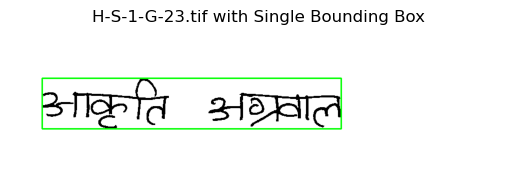

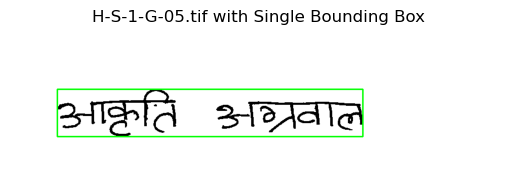

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(9.5410, grad_fn=<AddBackward0>)
c :  tensor(9.3433, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 87.29708862304688
Threshold :  tensor(4.8716, grad_fn=<RsubBackward1>)
002
H-S-2-G-01
H-S-2-G-24


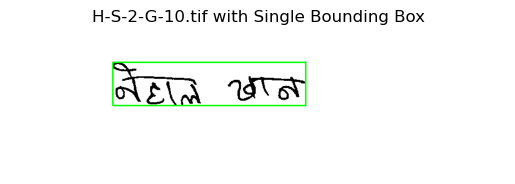

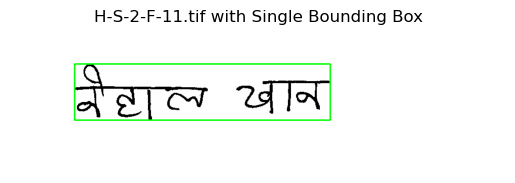

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Forged Pair
m : tensor(10.8370, grad_fn=<AddBackward0>)
c :  tensor(10.4794, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.12791815400123596
Threshold :  tensor(5.0504, grad_fn=<AddBackward0>)
003
H-S-3-G-01
H-S-3-G-24


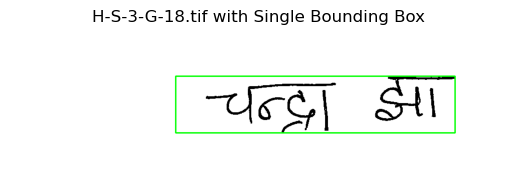

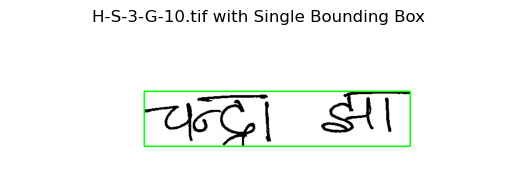

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(9.4702, grad_fn=<AddBackward0>)
c :  tensor(9.2969, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 86.43190002441406
Threshold :  tensor(9.6988, grad_fn=<AddBackward0>)
004
H-S-4-G-01
H-S-4-G-24


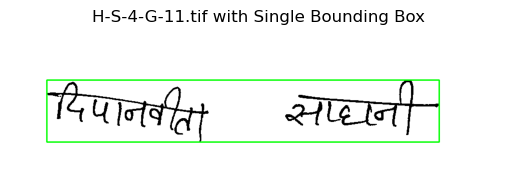

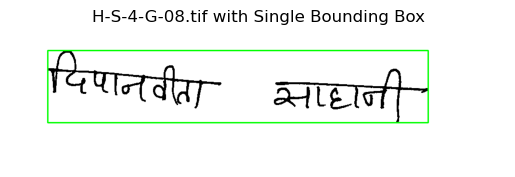

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(11.3136, grad_fn=<AddBackward0>)
c :  tensor(10.6676, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 113.79814910888672
Threshold :  tensor(15.0326, grad_fn=<AddBackward0>)
005
H-S-5-G-01
H-S-5-G-24


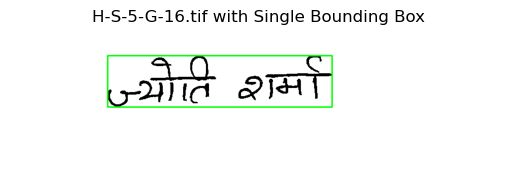

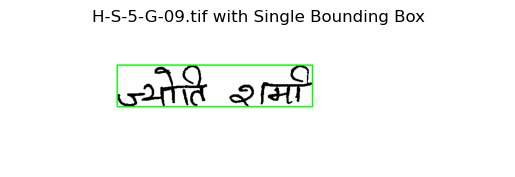

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(10.3351, grad_fn=<AddBackward0>)
c :  tensor(10.0061, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 100.12271881103516
Threshold :  tensor(10.0296, grad_fn=<SubBackward0>)
006
H-S-6-G-01
H-S-6-G-24


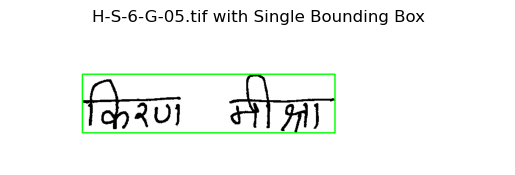

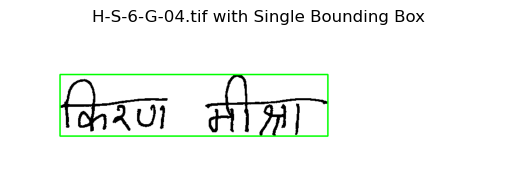

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(9.1646, grad_fn=<AddBackward0>)
c :  tensor(9.1305, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 83.36517333984375
Threshold :  tensor(5.4643, grad_fn=<SubBackward0>)
007
H-S-7-G-01
H-S-7-G-24


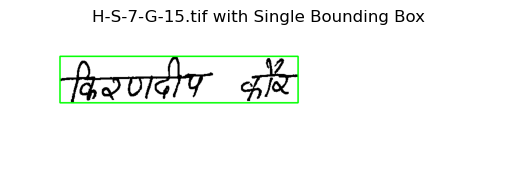

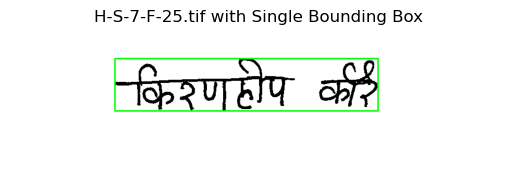

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Forged Pair
m : tensor(11.3807, grad_fn=<AddBackward0>)
c :  tensor(10.8749, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.255880206823349
Threshold :  tensor(5.7173, grad_fn=<AddBackward0>)
008
H-S-8-G-01
H-S-8-G-24


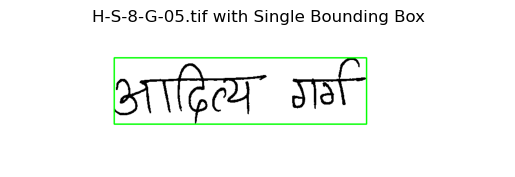

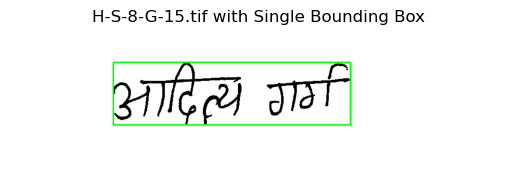

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(9.7349, grad_fn=<AddBackward0>)
c :  tensor(9.5109, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 90.45735168457031
Threshold :  tensor(10.4727, grad_fn=<AddBackward0>)
009
H-S-9-G-01
H-S-9-G-24


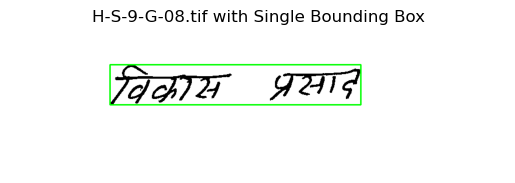

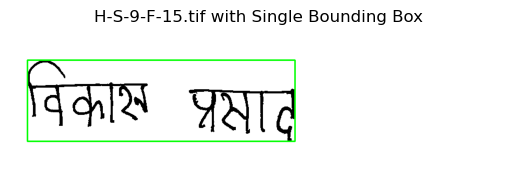

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Forged Pair
m : tensor(10.7145, grad_fn=<AddBackward0>)
c :  tensor(10.3010, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.17097343504428864
Threshold :  tensor(10.6795, grad_fn=<AddBackward0>)
010
H-S-10-G-01
H-S-10-G-24


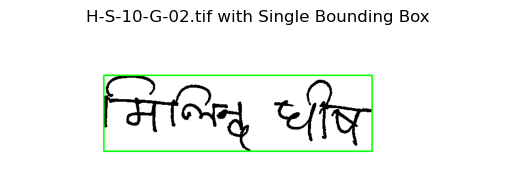

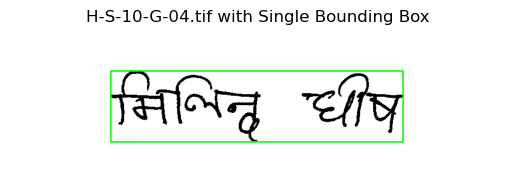

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(11.2033, grad_fn=<AddBackward0>)
c :  tensor(10.8105, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 116.86724090576172
Threshold :  tensor(16.0847, grad_fn=<AddBackward0>)
011
H-S-11-G-01
H-S-11-G-24


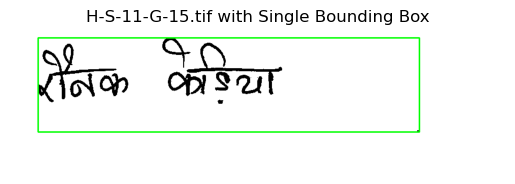

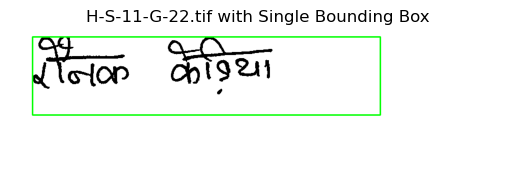

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(9.6360, grad_fn=<AddBackward0>)
c :  tensor(9.5311, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 90.8416748046875
Threshold :  tensor(11.3192, grad_fn=<SubBackward0>)
012
H-S-12-G-01
H-S-12-G-24


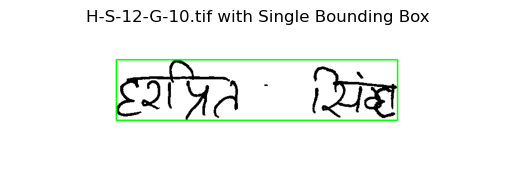

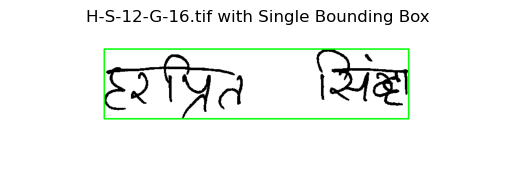

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(11.3627, grad_fn=<AddBackward0>)
c :  tensor(10.6451, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 113.31747436523438
Threshold :  tensor(16.6417, grad_fn=<AddBackward0>)
013
H-S-13-G-01
H-S-13-G-24


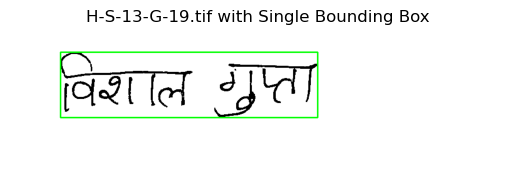

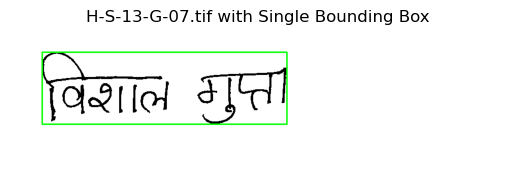

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(10.2459, grad_fn=<AddBackward0>)
c :  tensor(10.0146, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 100.29316711425781
Threshold :  tensor(11.6344, grad_fn=<SubBackward0>)
014
H-S-14-G-01
H-S-14-G-24


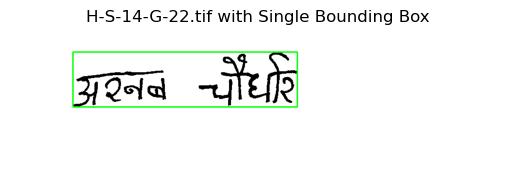

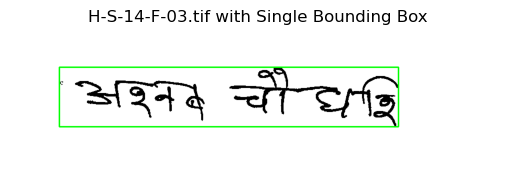

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Forged Pair
m : tensor(10.1375, grad_fn=<AddBackward0>)
c :  tensor(9.9583, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.03213902562856674
Threshold :  tensor(11.5448, grad_fn=<SubBackward0>)
015
H-S-15-G-01
H-S-15-G-24


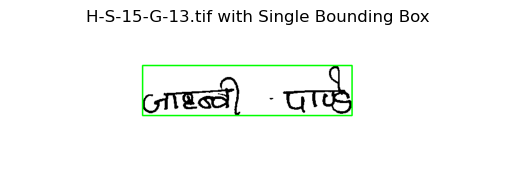

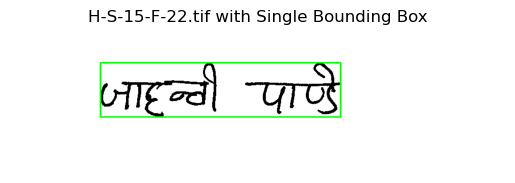

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Forged Pair
m : tensor(10.6177, grad_fn=<AddBackward0>)
c :  tensor(10.4563, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.026028672233223915
Threshold :  tensor(11.4641, grad_fn=<SubBackward0>)
016
H-S-16-G-01
H-S-16-G-24


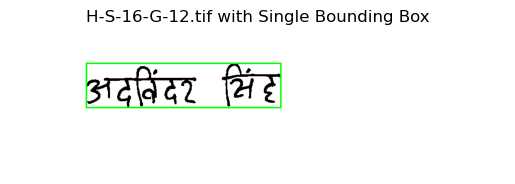

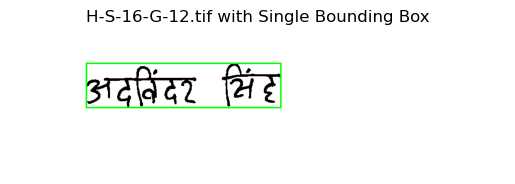

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(3.1265, grad_fn=<AddBackward0>)
c :  tensor(3.9183, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 15.352707862854004
Threshold :  tensor(9.5050, grad_fn=<SubBackward0>)
017
H-S-17-G-01
H-S-17-G-24
H-S-017-G-01
H-S-017-G-24


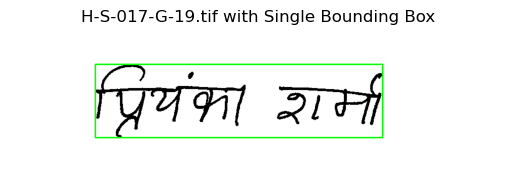

H-S-017-G-01
H-S-017-G-24


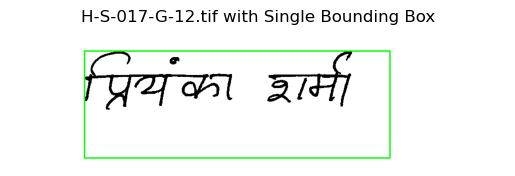

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(9.9525, grad_fn=<AddBackward0>)
c :  tensor(9.7298, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 94.66851043701172
Threshold :  tensor(14.3699, grad_fn=<AddBackward0>)
018
H-S-18-G-01
H-S-18-G-24
H-S-018-G-01
H-S-018-G-24


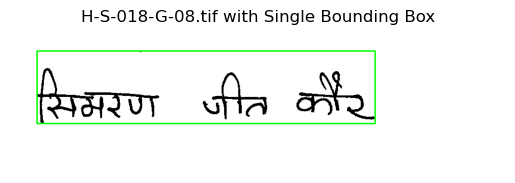

H-S-018-G-01
H-S-018-G-24


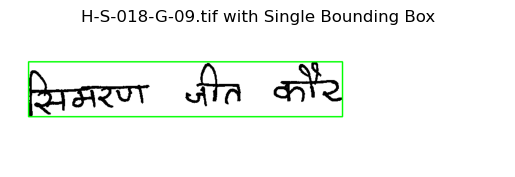

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(10.8493, grad_fn=<AddBackward0>)
c :  tensor(10.4299, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 108.78355407714844
Threshold :  tensor(9.1549, grad_fn=<SubBackward0>)
019
H-S-19-G-01
H-S-19-G-24


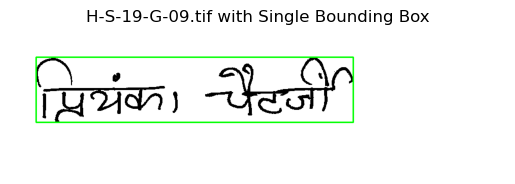

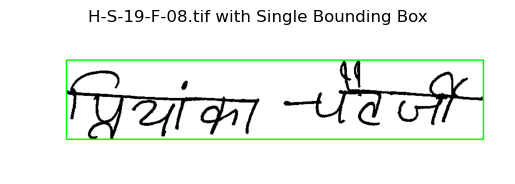

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Forged Pair
m : tensor(9.8484, grad_fn=<AddBackward0>)
c :  tensor(9.6760, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.029734091833233833
Threshold :  tensor(9.2411, grad_fn=<AddBackward0>)
020
H-S-20-G-01
H-S-20-G-24


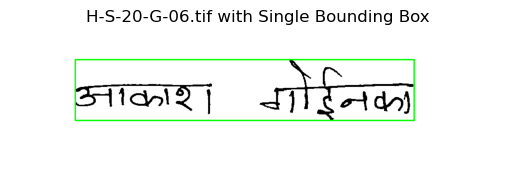

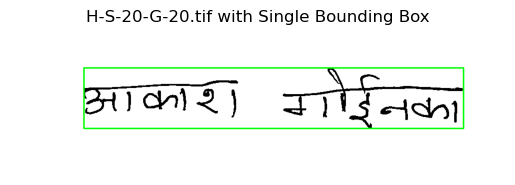

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(10.9032, grad_fn=<AddBackward0>)
c :  tensor(10.4919, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 110.07999420166016
Threshold :  tensor(14.4871, grad_fn=<AddBackward0>)
021
H-S-21-G-01
H-S-21-G-24


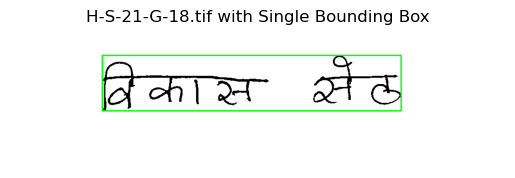

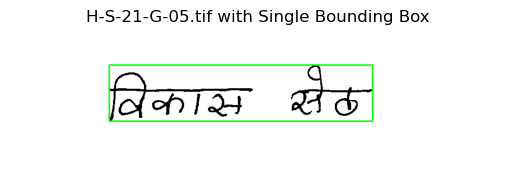

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(10.1701, grad_fn=<AddBackward0>)
c :  tensor(9.9876, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 99.75218200683594
Threshold :  tensor(9.4933, grad_fn=<SubBackward0>)
022
H-S-22-G-01
H-S-22-G-24


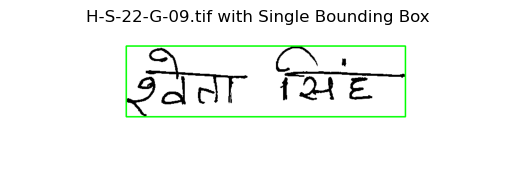

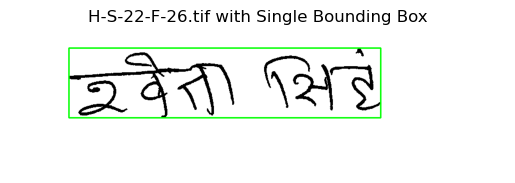

In [ ]:
# Path to the folder containing the images
directory_path = "C:\\Users\\Yashraj\\OneDrive - Indian Institute of Technology Patna\\Desktop\\MASCN_project\\BHSig260\\Hindi" 
# Get a list of all the language folder paths
# languages = [os.path.join(directory_path, lang) for lang in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, lang))]

# Get a list of all the folders in the directory
folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]
print(folders)

for folder_no in folders:
  print(folder_no)
  count = 0;
  while count < 1:
    count += 1
    folder_path = os.path.join(directory_path, folder_no)
    # all_images = [img for img in os.listdir(folder_path) if img.endswith('.tif')]
    cropped_image_genuine_name = image_processing_genuine(int(folder_no), folder_path);
    cropped_image_genforg_name, label = image_processing_genforg(int(folder_no), folder_path);
    pipeline(cropped_image_genuine_name, cropped_image_genforg_name, label)